
# Galaxy–Galaxy Strong Lensing (Roman Bands)

**Adapted from:** `notebooks/MainNotebooks/galaxy_galaxy_lensing_tutorial.ipynb` in the `slsim` repo (original uses LSST *gri*).  
**This version:** configures and runs the same workflow using **Roman WFI** bands (e.g., `F062, F087, F106, F129, F158, F184, F213`, plus the wide `F146`).

> 🔎 **What changed vs. the original?**
>
> - **Band system:** replaced LSST `g/r/i` with Roman `Fxxx` bands throughout.
> - **Filter definitions:** explicitly register Roman bandpasses with `speclite` using `slsim.Observations.roman_speclite` utilities.
> - **Population cuts:** switch magnitude cuts to Roman bands (defaults below use `F062` and `F184` where appropriate).
> - **Imaging config:** use `LensingPlots(..., observatory="Roman")`, which sets Roman WFI pixel scale/PSF/noise presets, and a larger `num_pix` than the LSST example.
> - **SkyPy config:** point to `data/SkyPy/roman-like.yml` so population magnitudes/colors are consistent with Roman filters.
>
> 💡 **Note on filter names:** Roman WFI filter names are `F062, F087, F106, F129, F158, F184, F213` (and `F146` wide). If you see `F067` in notes/scripts, treat it as a likely typo for `F062`.



## 0) Environment & dependencies

If running in a fresh environment, you may need:

```bash
pip install slsim lenstronomy speclite astropy corner skypy
```

Restart the kernel after installation if needed.


In [23]:
# 1) Imports

import os
import numpy as np
import matplotlib.pyplot as plt

import slsim
from slsim.Lenses.lens_pop import LensPop
from slsim.Plots.lens_plots import LensingPlots

# Roman-specific helpers (provided by slsim)
from slsim.Pipelines.roman_speclite import configure_roman_filters
from slsim.Pipelines.roman_speclite import filter_names
import slsim.Pipelines as pipelines

import speclite
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
import corner

# matplotlib inline for notebooks
%matplotlib inline


## 1) Roman filters vs LSST bands (deviation from original)

The original notebook assumes LSST imaging and uses `g/r/i` for both **cuts** (e.g., `kwargs_*_cut`) and **rendering**.  
Here we:
- **Register** Roman filters with `speclite` via `configure_roman_filters()` and `speclite.filters.load_filters(...)`.
- Use Roman bands in all magnitude-based selections and plots.
- Switch `LensingPlots` to `observatory="Roman"` so the PSF, pixel scale, and noise are appropriate for Roman WFI.


In [24]:

# 2) Configure & register the Roman WFI filter set in speclite

# Create (if needed) and expose Roman bandpasses to speclite
configure_roman_filters()

roman_filters_names = filter_names()  # e.g. ['Roman-F062', 'Roman-F087', ..., 'Roman-F213', 'Roman-F146']

# Ensure speclite knows these bandpasses for magnitude calculations inside slsim
roman_filters = speclite.filters.load_filters(
    roman_filters_names[0],
    roman_filters_names[1],
    roman_filters_names[2],
    roman_filters_names[3],
    roman_filters_names[4],
    roman_filters_names[5],
    roman_filters_names[6],
    roman_filters_names[7],
)

print("Registered Roman filters:", roman_filters)


Registered Roman filters: <speclite.filters.FilterSequence object at 0x7f5dfdb7a230>



## 2) SkyPy configuration (deviation from original)

The LSST tutorial uses the default SkyPy config (`skypy_config=None`). To make colors/magnitudes consistent with Roman,
we use the **Roman-like** SkyPy configuration that ships with `slsim`:
`data/SkyPy/roman-like.yml`.


In [25]:

# 3) Paths, cosmology, and sky area

# Point to the built-in Roman-like SkyPy configuration file
slsim_path = os.path.dirname(slsim.__file__)
module_path, _ = os.path.split(slsim_path)
skypy_config = os.path.join(module_path, "data", "SkyPy", "roman-like.yml")

# Cosmology and survey area (tweak as needed)
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
sky_area = Quantity(value=0.1, unit="deg2")  # similar scale to the original tutorial
print("Using SkyPy config:", skypy_config)


Using SkyPy config: /pscratch/sd/e/emlin/lensedsupernovae/slsim/data/SkyPy/roman-like.yml



## 3) Population definition & magnitude cuts (deviation from original)

**Original:** cut on `g` band (e.g., `kwargs_deflector_cut = {"band": "g", ...}`).  
**Roman version:** cut on Roman bands. We pick `F062` for a blue/optical-like cut and allow relatively faint sources.
You can change these to any Roman band, e.g., `F184` for redder selection.

We also choose Roman bands for the *arc magnitude* limits used when plotting/realizing systems.


In [26]:
def add_roman_magnitudes(table):
    """
    Add approximate Roman magnitudes to a SkyPy galaxy table
    that only has g,r,i,z,y bands.
    """
    g, r, i, z, y = [table[f'mag_{b}'] for b in ['g','r','i','z','y']]

    table['mag_F062'] = g                        # F062 ~ g
    table['mag_F087'] = 0.5*(r + i)              # F087 ~ midpoint of r & i
    table['mag_F106'] = i                        # F106 ~ i
    table['mag_F129'] = 0.5*(i + z)              # F129 ~ midpoint of i & z
    table['mag_F146'] = z                        # F146 ~ z
    table['mag_F158'] = 0.5*(z + y)              # F158 ~ midpoint of z & y
    table['mag_F184'] = y                        # F184 ~ y
    table['mag_F213'] = y + 0.3                  # F213 ~ y + 0.3 mag (crude extrapolation)

    return table

In [27]:
from slsim.Lenses.lens_pop import LensPop
from slsim.Deflectors.DeflectorPopulation.all_lens_galaxies import AllLensGalaxies
from slsim.Sources.SourcePopulation.galaxies import Galaxies

# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area to render lenses for
sky_area = Quantity(value=10, unit="deg2")

# define sky area to render sources from (can be smaller if sample noise is suppressed enough)
sky_area_galaxies = Quantity(value=0.5, unit="deg2")


# Roman band selection cuts
kwargs_deflector_cut = {"band": "F062", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut    = {"band": "F062", "band_max": 28, "z_min": 0.1,  "z_max": 5.0}


In [28]:
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None, sky_area=sky_area_galaxies, filters=roman_filters, cosmo=cosmo
)

In [29]:
# Load or create deflector tables
# In the tutorial these come from skypy_config or slsim defaults
# Here we pass None or empty arrays to use defaults if your branch supports it
red_galaxy_list  = galaxy_simulation_pipeline.red_galaxies  # or slsim provides a helper to load a default table
blue_galaxy_list = galaxy_simulation_pipeline.blue_galaxies  # same
kwargs_mass2light = None  # keep default scaling if desired

red_galaxy_list  = add_roman_magnitudes(red_galaxy_list)
blue_galaxy_list = add_roman_magnitudes(blue_galaxy_list)

In [30]:
print(red_galaxy_list.colnames)

['z', 'M', 'coeff', 'ellipticity', 'physical_size', 'stellar_mass', 'angular_size', 'mag_g', 'mag_r', 'mag_i', 'mag_z', 'mag_y', 'mag_F062', 'mag_F087', 'mag_F106', 'mag_F129', 'mag_F146', 'mag_F158', 'mag_F184', 'mag_F213']


In [31]:
# Instantiate the deflector population
deflector_pop = AllLensGalaxies(
    red_galaxy_list=red_galaxy_list,
    blue_galaxy_list=blue_galaxy_list,
    kwargs_mass2light=kwargs_mass2light,
    kwargs_cut=kwargs_deflector_cut,
    cosmo=cosmo,
    sky_area=sky_area
)

/pscratch/sd/e/emlin/lensedsupernovae/slsim/slsim/Deflectors/DeflectorPopulation/all_lens_galaxies.py:56: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  red_galaxy_list = catalog_with_angular_size_in_arcsec(
/pscratch/sd/e/emlin/lensedsupernovae/slsim/slsim/Deflectors/DeflectorPopulation/all_lens_galaxies.py:59: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  blue_galaxy_list = catalog_with_angular_size_in_arcsec(


In [32]:
# Instantiate the source population
source_pop = Galaxies(
    galaxy_list=blue_galaxy_list,
    kwargs_cut=kwargs_source_cut,
    cosmo=cosmo,
    sky_area=sky_area,
    # catalog_type="skypy",
    extended_source_type="single_sersic",
)

In [33]:
# Instantiate LensPop
gg_lens_pop = LensPop(
    deflector_population=deflector_pop,
    source_population=source_pop,
    cosmo=cosmo,
    sky_area=sky_area
)

gg_lens_pop



## 4) Random realizations & imaging (deviation from original)

**Original:** `LensingPlots(gg_lens_pop, num_pix=64, coadd_years=10)` with LSST defaults and `rgb_band_list=["i", "r", "g"]`.

**Roman version:**
- `observatory="Roman"` to pick Roman presets (PSF, pixel scale, read noise, sky).
- Use a somewhat larger `num_pix` (e.g., `124`) to leverage Roman's finer sampling.
- `rgb_band_list=["F184", "F129", "F062"]` is a good R/G/B mapping (redder to bluer). Adjust to taste.
- The `mag_arc_limit` keys must now be Roman band names. Values below are conservative demo values—tune for your case.


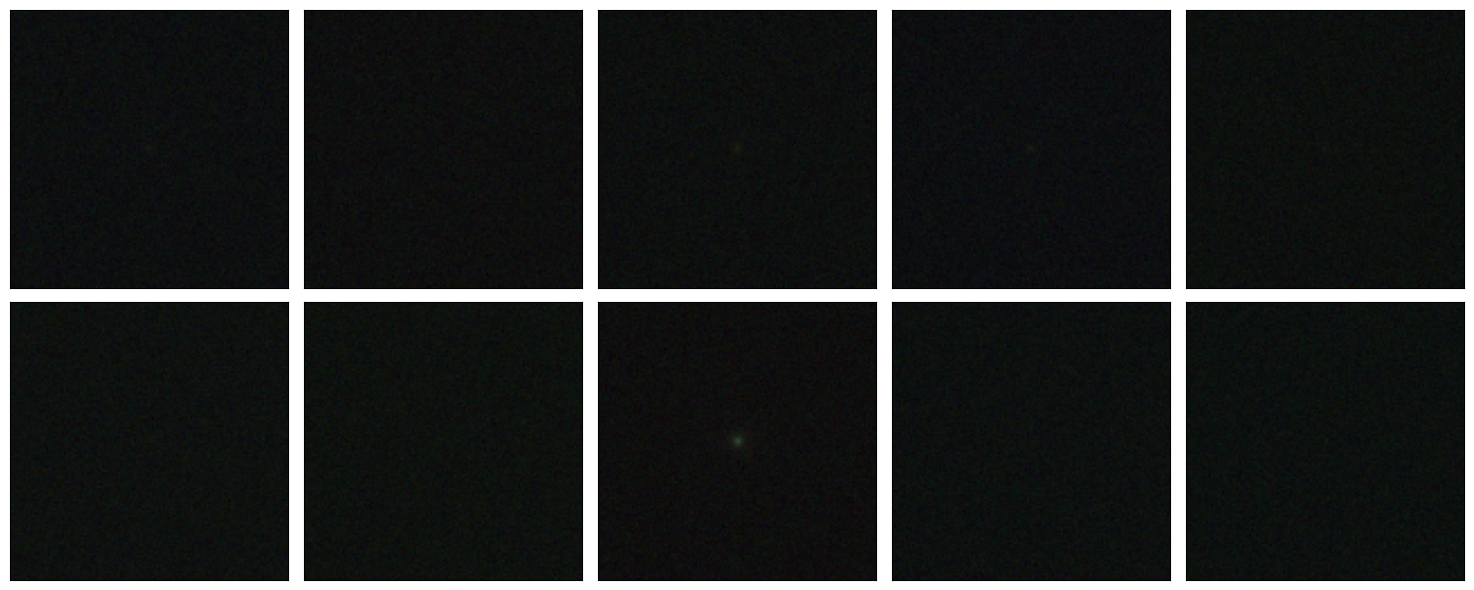

In [35]:

# 5) Render a small montage of random galaxy–galaxy lenses with Roman imaging

kwargs_lens_cut_plot = {
    "min_image_separation": 0.5,
    "max_image_separation": 10,
    "mag_arc_limit": {"F158": 21, "F129": 21, "F062": 21},
}

gg_plot = LensingPlots(gg_lens_pop, num_pix=124, observatory="Roman")

fig, axes = gg_plot.plot_montage(
    rgb_band_list=["F184", "F129", "F062"],
    add_noise=True,
    n_horizont=5,
    n_vertical=2,
    kwargs_lens_cut=kwargs_lens_cut_plot,
)
plt.show()



## 5) Draw the full population (unchanged logic, band names updated)

The Monte Carlo sampling logic matches the original notebook; only the **band keys** in the magnitude cut dictionary change.


In [ ]:
# 6) Draw the population with a Roman-band magnitude limit for arcs

kwargs_lens_cuts = {"mag_arc_limit": {"F184": 28}}  # pick your preferred band/limit here
gg_lens_population = gg_lens_pop.draw_population(kwargs_lens_cuts=kwargs_lens_cuts)

print("Number of lenses:", len(gg_lens_population))



## 6) Corner plot of key quantities (band names updated where needed)

As in the original tutorial, we calculate: velocity dispersion, stellar mass, Einstein radius, lens/source redshifts,
and apparent magnitudes. We query magnitudes in a **Roman band** (e.g., `F184`). Change bands to explore color dependencies.


In [ ]:

# 7) Make the corner plot

lens_samples = []
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm source}$",
    r"$m_{\rm lens}$",
]

for gg_lens in gg_lens_population:
    vel_disp = gg_lens.deflector_velocity_dispersion()
    m_star = gg_lens.deflector_stellar_mass()
    theta_e = gg_lens.einstein_radius
    zl = gg_lens.deflector_redshift
    zs = gg_lens.source_redshift
    source_mag = gg_lens.extended_source_magnitude(band="F184", lensed=True)
    deflector_mag = gg_lens.deflector_magnitude(band="F184")
    lens_samples.append([vel_disp, np.log10(m_star), theta_e, zl, zs, source_mag, deflector_mag])

hist2dkwargs = {
    "plot_density": False,
    "plot_contours": False,
    "plot_datapoints": True,
    "color": "b",
    "data_kwargs": {"ms": 5},
}
corner.corner(np.array(lens_samples), labels=labels, **hist2dkwargs)
plt.show()



## 7) Sanity checks & tips

- If you get errors about unknown filters, re-run the **Roman filter registration** cell and verify `roman_filters` prints as expected.
- You can swap the selection/plotting bands anywhere with a Roman `Fxxx` string; the supported set is printed by `filter_names()`.
- To emulate LSST-like color choices in Roman space: try **blue**=`F062`, **green**=`F106` or `F129`, **red**=`F184`.
- For higher resolution stamps, increase `num_pix` (and potentially the field of view if exposed by your version of `LensingPlots`).
- If your `slsim` version lacks `Observations.roman_speclite`, update `slsim` to a recent commit.



## Appendix: Rough band mapping (LSST → Roman)

This is only for intuition when porting thresholds; always check actual throughput curves for precise work.

| LSST (approx) | Roman (approx) |
|---|---|
| g | F062 |
| r | F087 / F106 |
| i | F129 |
| z | F158 |
| y | F184 / F213 |

> Roman also provides a very wide `F146` (W146) band that spans much of the near-IR.
